# Определение стоимости автомобилей

**Описание проекта:**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**Примечания:**

- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del: del features_train

**Описание данных:**

Данные находятся в файле /datasets/autos.csv.

**Признаки:**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**

- Price — цена (евро)

## Подготовка данных

In [ ]:
! pip install CatBoost

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

Выгружу данные из таблицы и изучу их.

In [ ]:
try:
    autos_data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
except:
    autos_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/toxic_comments.csv')

In [ ]:
display(autos_data.info())
autos_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf     150000                  0    petrol  volkswagen         NaN   
1    NaN     125000                  5  gasoline        audi         yes   
2  grand     125000                  8  gasoline        jeep         NaN   
3   golf     150000                  6    petrol  volkswagen          no   
4  fabia      90000                  7  gasoline       skoda          no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

Оценю количество пропусков по каждому критерию.

In [ ]:
autos_data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Столбцы VehicleType, Gearbox, FuelType и NotRepaired обладают пропусками. Изучу, какие данные есть в каждом столбце.

In [ ]:
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())

Функция для отображения уникальных значений

In [ ]:
show_rows(autos_data)

Уникальные значения столбца DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Уникальные значения столбца Price
[  480 18300  9800 ... 12395 18429 10985]
Уникальные значения столбца VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения столбца RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290

* В столбце RegistrationYear существуют некорректные значения года регистрации.
* В столбце RegistrationMonth отсутсвует месяц регистрации.
* В столбце Power присутвует некорректное значение мощности.

Определим признаки, важные для модели.

К значимым признакам отнесем следующие столбцы:

* VehicleType. Тип машины определяет ее функционал. Чем больше возможносей у машины, тем выше цена.
* Gearbox. Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.
* Power. Мощность в лоашдиных силах (далее л.с.) напрямую влияют на цену.
* Kilometer. Имеет обратно пропорциональную зависиммость от цены. Чем больше километров проехала машина, тем меньше ее надежность и соответсвенно цена.
* FuelType. Тип топлива определяет конструкцию двигателя внутреннего сгорания.
* Brand. Концерн/компания, которая создала автомобиль показывает качество и надежность автомобиля.
* NotRepaired. Машины, которые побывали в дорожно-транспортных проишествиях означает, что машина подвергалась изменениям и ее надежность ниже.
* RegistrationYear. Год регистрации определяет сколько уже лет машина на ходу. соответвенно, чем больше возраст, тем меньше цена.
* Model. В купе с типом машины и брендом може влиять на популярность у покупателей.

Остальные столбцы для модели не требуются, так как не влияют на стоимость.

In [ ]:
autos_data.describe().T

count           mean           std     min       25%  \
Price              354369.0    4416.656776   4514.158514     0.0    1050.0   
RegistrationYear   354369.0    2004.234448     90.227958  1000.0    1999.0   
Power              354369.0     110.094337    189.850405     0.0      69.0   
Kilometer          354369.0  128211.172535  37905.341530  5000.0  125000.0   
RegistrationMonth  354369.0       5.714645      3.726421     0.0       3.0   
NumberOfPictures   354369.0       0.000000      0.000000     0.0       0.0   
PostalCode         354369.0   50508.689087  25783.096248  1067.0   30165.0   

                        50%       75%       max  
Price                2700.0    6400.0   20000.0  
RegistrationYear     2003.0    2008.0    9999.0  
Power                 105.0     143.0   20000.0  
Kilometer          150000.0  150000.0  150000.0  
RegistrationMonth       6.0       9.0      12.0  
NumberOfPictures        0.0       0.0       0.0  
PostalCode          49413.0   71083.0   99998.0

Отображение сводной информации датафрейма в транпонированом виде

### Предобработка данных

Сокращу дата фрейм до нужных столбцов.

In [ ]:
filtred_autos_data = autos_data[['VehicleType', 
                         'Gearbox', 
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'NotRepaired',
                         'RegistrationYear',
                         'Model',
                         'Price']]
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   Gearbox           334536 non-null  object
 2   Power             354369 non-null  int64 
 3   Kilometer         354369 non-null  int64 
 4   FuelType          321474 non-null  object
 5   Brand             354369 non-null  object
 6   NotRepaired       283215 non-null  object
 7   RegistrationYear  354369 non-null  int64 
 8   Model             334664 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Столбцы, требующие обработки:

* VehicleType. Восстановим пропущенные значения по популярному типу из столбца Brand.
* Gearbox. Для всех NaN установим значение 'manual'.
* Power. Скоректируем на основе реальных значений в машинах. Иметь 1 л.с. или 15000 л.с. для машины на данный момент нереально.
* FuelType. Восстановим пропущенные значения по популярному типу из столбца Brand.
* NotRepaired. Для всех NaN установим значение 'yes'.
* RegistrationYear. Скоректируем на основе реальных значений в машинах.
* Model. Для всех NaN установим значение 'unknown'.

Проверю наполнение целевого признака Price.

In [ ]:
filtred_autos_data['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: Price, Length: 3731, dtype: int64

Видно, что существует 10772 записи без цены. Удалю их и проверю распределение цены на гистограмме.

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

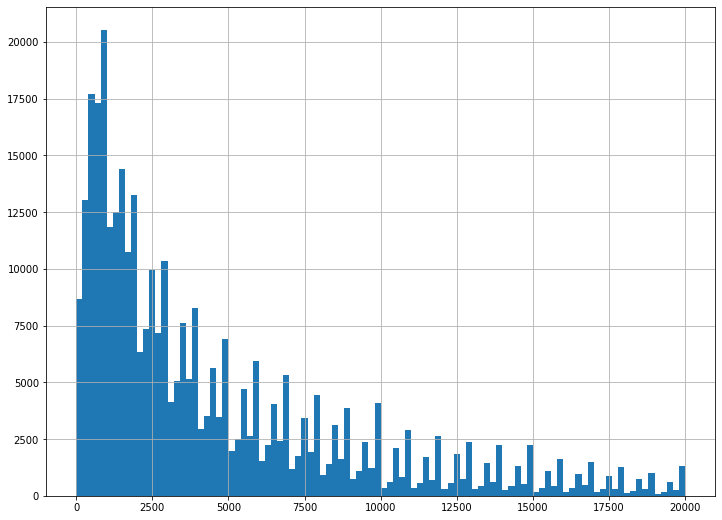

In [ ]:
filtred_autos_data = filtred_autos_data.query('Price > 0')
filtred_autos_data['Price'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Price'].describe()

Выделю квантили 5% и 80%.

In [ ]:
filtred_autos_data['Price'].quantile([.05, 0.8])

0.05     350.0
0.80    7800.0
Name: Price, dtype: float64

Стоимость 350 евро примерно равно 28000 рублей. Это минимальная цена для продажи поддержанного авто. Выбор 80% квантиля обоснован болльшими выбросами после 7500 евро.

In [ ]:
filtred_autos_data = filtred_autos_data.query('350 <= Price <= 7800')
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259798 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       233267 non-null  object
 1   Gearbox           246646 non-null  object
 2   Power             259798 non-null  int64 
 3   Kilometer         259798 non-null  int64 
 4   FuelType          236972 non-null  object
 5   Brand             259798 non-null  object
 6   NotRepaired       206998 non-null  object
 7   RegistrationYear  259798 non-null  int64 
 8   Model             246358 non-null  object
 9   Price             259798 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 21.8+ MB


Проверю значения столбца RegistrationYear на гистограмме.

count    259798.000000
mean       2002.844976
std          65.140145
min        1000.000000
25%        1999.000000
50%        2002.000000
75%        2006.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

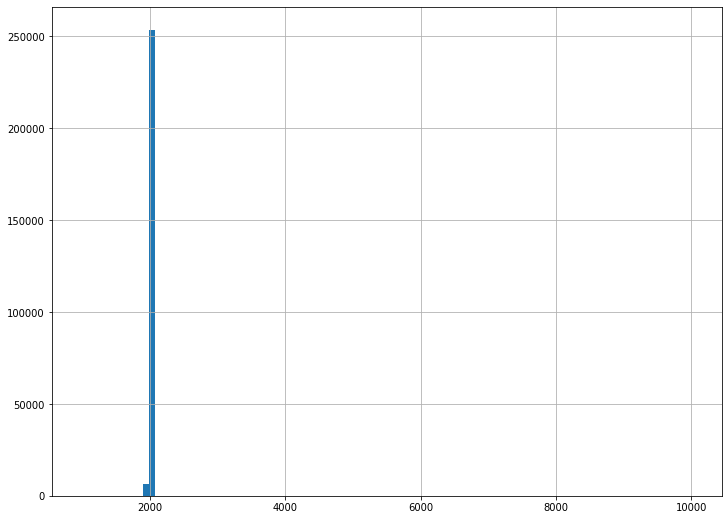

In [ ]:
filtred_autos_data['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_autos_data['RegistrationYear'].describe()

В годе регистрации наблюдаются выбросы. Отсеку правые выбросы, узнав максимальную дату скачивания анкеты автомобиля.

In [ ]:
date = pd.to_datetime(autos_data['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

Даты регистрации после 2016 года некорректны и машины появились не раньше 1900 года. Отсечем ненужные года и промотрим левые выбросы.

count    247788.000000
mean       2001.539179
std           6.112319
min        1910.000000
25%        1998.000000
50%        2002.000000
75%        2005.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

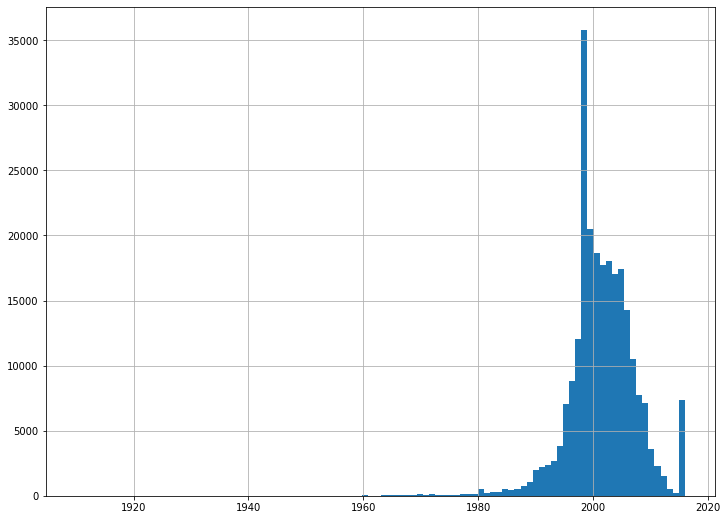

In [ ]:
filtred_autos_data = filtred_autos_data.query('1899 < RegistrationYear < 2017')
filtred_autos_data['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_autos_data['RegistrationYear'].describe()

По левой части гистограммы видно, что адекватно использовать левую границу в 1960 год, так как это старые, но возможно еще работающие машины.

count    247665.000000
mean       2001.567440
std           5.968335
min        1960.000000
25%        1998.000000
50%        2002.000000
75%        2005.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

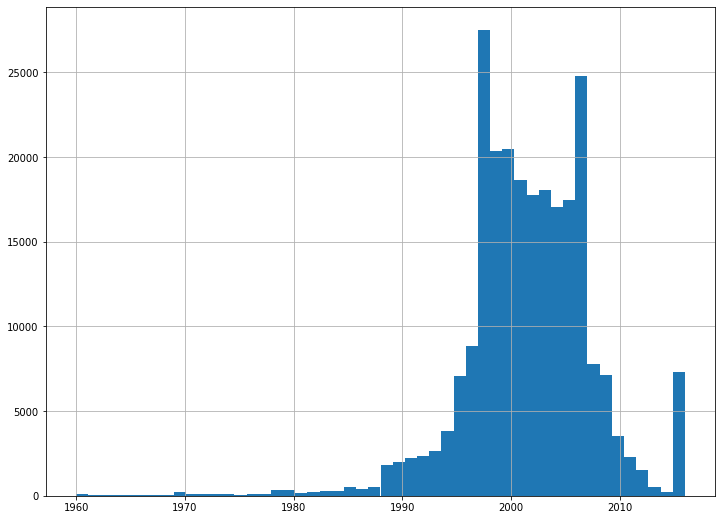

In [ ]:
filtred_autos_data = filtred_autos_data.query('1959 < RegistrationYear < 2017')
filtred_autos_data['RegistrationYear'].hist(bins=50, figsize=(12,9))
filtred_autos_data['RegistrationYear'].describe()

Проведем замену NaN в Gearbox, NotRepaired и Model.

In [ ]:
filtred_autos_data.fillna({'Gearbox':'manual', 
                           'NotRepaired':'unknown_repair',
                           'Model':'unknown'},
                          inplace=True)
filtred_autos_data.isna().mean()

VehicleType         0.058640
Gearbox             0.000000
Power               0.000000
Kilometer           0.000000
FuelType            0.073575
Brand               0.000000
NotRepaired         0.000000
RegistrationYear    0.000000
Model               0.000000
Price               0.000000
dtype: float64

Оценю количество пропущенных значений относительно всех значений в столбце VehicleType

In [ ]:
display(filtred_autos_data['VehicleType'].value_counts())
filtred_autos_data['VehicleType'].isna().sum()

sedan          67609
small          66486
wagon          47300
bus            21087
convertible    12662
coupe          10311
suv             5237
other           2450
Name: VehicleType, dtype: int64

14523

Выполним замену NaN в соотвествии с популярным типом кузова для каждого бренда.

In [ ]:
vehicle_type_pivot_table = filtred_autos_data.pivot_table(index=['VehicleType'], 
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
display(vehicle_type_pivot_table)
filtred_autos_data[filtred_autos_data['Brand'] == 'alfa_romeo']['VehicleType'].value_counts()

count                                                     \
                 Price                                                      
Brand       alfa_romeo    audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                 
bus                NaN    10.0      4.0      98.0    370.0  1040.0   15.0   
convertible      111.0   667.0   1636.0       6.0    195.0    96.0    NaN   
coupe            180.0   651.0   2570.0      45.0     17.0   137.0    NaN   
other             10.0    83.0    187.0      18.0      6.0    95.0    5.0   
sedan            777.0  7828.0  11309.0     146.0    205.0   538.0   97.0   
small            185.0   933.0    324.0     574.0     12.0  1372.0  178.0   
suv                NaN    18.0    189.0     146.0     12.0     8.0   46.0   
wagon            388.0  6422.0   4997.0      83.0    183.0   497.0  227.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           26.0     31.0   707.0  ...   485.0   158.0     1.0   
convertible    1.0      8.0   257.0  ...     NaN     3.0   988.0   
coupe          2.0      NaN   151.0  ...    64.0     6.0   318.0   
other          5.0      9.0   151.0  ...    47.0    21.0     8.0   
sedan         87.0     35.0   796.0  ...  1220.0   694.0    26.0   
small        247.0    439.0  4520.0  ...  2621.0   930.0  3099.0   
suv            1.0     46.0    17.0  ...     1.0     7.0     NaN   
wagon         36.0     16.0   370.0  ...   215.0  1763.0     9.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  140.0   16.0   27.0   341.0     NaN     5936.0     NaN  
convertible          161.0    NaN   32.0    47.0    30.0     2029.0    35.0  
coupe                 79.0    3.0    4.0   178.0     2.0      740.0    50.0  
other                167.0    5.0   10.0    15.0     4.0      586.0     NaN  
sedan                257.0   99.0  131.0   735.0   170.0    14847.0   487.0  
small                166.0   99.0  810.0  1475.0    49.0    15294.0     6.0  
suv                  174.0   42.0  557.0   252.0     NaN      247.0    30.0  
wagon                104.0  241.0   84.0   449.0    66.0     9704.0  1655.0  

[8 rows x 40 columns]

sedan          777
wagon          388
small          185
coupe          180
convertible    111
other           10
Name: VehicleType, dtype: int64

In [ ]:
vehicle_type_pivot_table = vehicle_type_pivot_table['count']['Price']
vehicle_type_pivot_table

Brand        alfa_romeo    audi      bmw  chevrolet  chrysler  citroen  dacia  \
VehicleType                                                                     
bus                 NaN    10.0      4.0       98.0     370.0   1040.0   15.0   
convertible       111.0   667.0   1636.0        6.0     195.0     96.0    NaN   
coupe             180.0   651.0   2570.0       45.0      17.0    137.0    NaN   
other              10.0    83.0    187.0       18.0       6.0     95.0    5.0   
sedan             777.0  7828.0  11309.0      146.0     205.0    538.0   97.0   
small             185.0   933.0    324.0      574.0      12.0   1372.0  178.0   
suv                 NaN    18.0    189.0      146.0      12.0      8.0   46.0   
wagon             388.0  6422.0   4997.0       83.0     183.0    497.0  227.0   

Brand        daewoo  daihatsu    fiat  ...    seat   skoda   smart  \
VehicleType                            ...                           
bus            26.0      31.0   707.0  ...   485.0   158.0     1.0   
convertible     1.0       8.0   257.0  ...     NaN     3.0   988.0   
coupe           2.0       NaN   151.0  ...    64.0     6.0   318.0   
other           5.0       9.0   151.0  ...    47.0    21.0     8.0   
sedan          87.0      35.0   796.0  ...  1220.0   694.0    26.0   
small         247.0     439.0  4520.0  ...  2621.0   930.0  3099.0   
suv             1.0      46.0    17.0  ...     1.0     7.0     NaN   
wagon          36.0      16.0   370.0  ...   215.0  1763.0     9.0   

Brand        sonstige_autos  subaru  suzuki  toyota  trabant  volkswagen  \
VehicleType                                                                
bus                   140.0    16.0    27.0   341.0      NaN      5936.0   
convertible           161.0     NaN    32.0    47.0     30.0      2029.0   
coupe                  79.0     3.0     4.0   178.0      2.0       740.0   
other                 167.0     5.0    10.0    15.0      4.0       586.0   
sedan                 257.0    99.0   131.0   735.0    170.0     14847.0   
small                 166.0    99.0   810.0  1475.0     49.0     15294.0   
suv                   174.0    42.0   557.0   252.0      NaN       247.0   
wagon                 104.0   241.0    84.0   449.0     66.0      9704.0   

Brand         volvo  
VehicleType          
bus             NaN  
convertible    35.0  
coupe          50.0  
other           NaN  
sedan         487.0  
small           6.0  
suv            30.0  
wagon        1655.0  

[8 rows x 40 columns]

Заполню словарь брендов и популярных типов машин и заполню пропуски по столбцу VehicleType.

In [ ]:
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247665 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       233142 non-null  object
 1   Gearbox           247665 non-null  object
 2   Power             247665 non-null  int64 
 3   Kilometer         247665 non-null  int64 
 4   FuelType          229443 non-null  object
 5   Brand             247665 non-null  object
 6   NotRepaired       247665 non-null  object
 7   RegistrationYear  247665 non-null  int64 
 8   Model             247665 non-null  object
 9   Price             247665 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 20.8+ MB


In [ ]:
filtred_autos_data.fillna({'VehicleType':0},inplace=True)

def fillna_by_brand(row, row_number, vehicle_type_pivot_table):
    brand = row[5]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type_pivot_table[brand].idxmax()
    return fill_value

filtred_autos_data['VehicleType'] = filtred_autos_data.apply(
                                fillna_by_brand, 
                                args=[0, vehicle_type_pivot_table],
                                axis=1)
display(filtred_autos_data['VehicleType'].isna().sum())
filtred_autos_data['VehicleType'].value_counts()

0

small          76545
sedan          71693
wagon          47556
bus            21144
convertible    12662
coupe          10330
suv             5285
other           2450
Name: VehicleType, dtype: int64

Заполню пропуски в FuelType по похожему принципу.

In [ ]:
filtred_autos_data['FuelType'].value_counts()
fuel_type_pivot_table = filtred_autos_data.pivot_table(index=['FuelType'], 
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
fuel_type_pivot_table = fuel_type_pivot_table['count']['Price']
display(fuel_type_pivot_table)

filtred_autos_data.fillna({'FuelType':0},inplace=True)

filtred_autos_data['FuelType'] = filtred_autos_data.apply(
                                fillna_by_brand, 
                                args=[4, vehicle_type_pivot_table],
                                axis=1)
display(filtred_autos_data['FuelType'].isna().sum())
filtred_autos_data['FuelType'].value_counts()

Brand     alfa_romeo    audi      bmw  chevrolet  chrysler  citroen  dacia  \
FuelType                                                                     
cng              NaN     1.0      6.0        4.0       NaN      7.0    2.0   
electric         NaN     1.0      3.0        NaN       NaN      NaN    NaN   
gasoline       480.0  6502.0   5073.0       66.0     264.0   1181.0   98.0   
hybrid           NaN     NaN      NaN        NaN       NaN      NaN    NaN   
lpg             30.0   356.0    606.0      139.0      77.0     63.0   35.0   
other            NaN     2.0      5.0        NaN       NaN      2.0    NaN   
petrol        1124.0  9465.0  14948.0      884.0     642.0   2499.0  424.0   

Brand     daewoo  daihatsu    fiat  ...    seat   skoda   smart  \
FuelType                            ...                           
cng          NaN       NaN    63.0  ...     NaN     4.0     2.0   
electric     NaN       1.0     2.0  ...     NaN     NaN     1.0   
gasoline     1.0       4.0  1243.0  ...  1229.0  1145.0   807.0   
hybrid       NaN       NaN     3.0  ...     1.0     NaN     1.0   
lpg         23.0       5.0    64.0  ...    56.0    48.0     3.0   
other        1.0       NaN     3.0  ...     NaN     NaN     1.0   
petrol     374.0     564.0  5496.0  ...  3333.0  2333.0  3604.0   

Brand     sonstige_autos  subaru  suzuki  toyota  trabant  volkswagen   volvo  
FuelType                                                                       
cng                  NaN     2.0     NaN     NaN      NaN       125.0    14.0  
electric            16.0     NaN     NaN     NaN      NaN         1.0     NaN  
gasoline           297.0    10.0   145.0   679.0      1.0     16655.0   582.0  
hybrid               NaN     NaN     NaN    35.0      NaN         5.0     NaN  
lpg                 58.0    25.0    18.0    18.0      NaN       454.0   100.0  
other               16.0     NaN     1.0     NaN     31.0        14.0     2.0  
petrol             784.0   453.0  1457.0  2736.0    242.0     31839.0  1507.0  

[7 rows x 40 columns]

0

petrol      162858
gasoline     61661
small        12152
sedan         5523
lpg           4241
cng            431
wagon          390
other          115
hybrid          83
bus             74
suv             62
electric        54
coupe           21
Name: FuelType, dtype: int64

In [ ]:
filtred_autos_data.isna().mean()

VehicleType         0.0
Gearbox             0.0
Power               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
NotRepaired         0.0
RegistrationYear    0.0
Model               0.0
Price               0.0
dtype: float64

Пропуски убраны. Теперь некорректные значения в столбце Power.

count    247665.000000
mean        102.053181
std         182.583893
min           0.000000
25%          67.000000
50%         101.000000
75%         131.000000
max       20000.000000
Name: Power, dtype: float64

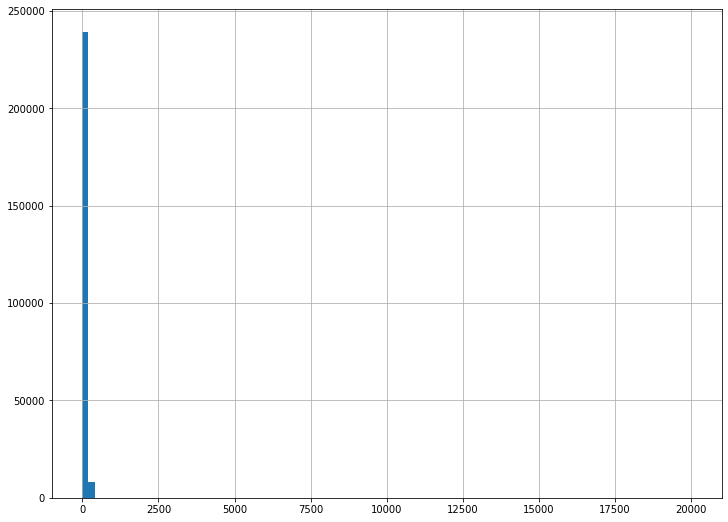

In [ ]:
filtred_autos_data['Power'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Power'].describe()

Раброс очень сильный, усечем выбросы больше 1000 л.с.

count    247451.000000
mean         98.693652
std          54.774902
min           0.000000
25%          67.000000
50%         101.000000
75%         131.000000
max        1000.000000
Name: Power, dtype: float64

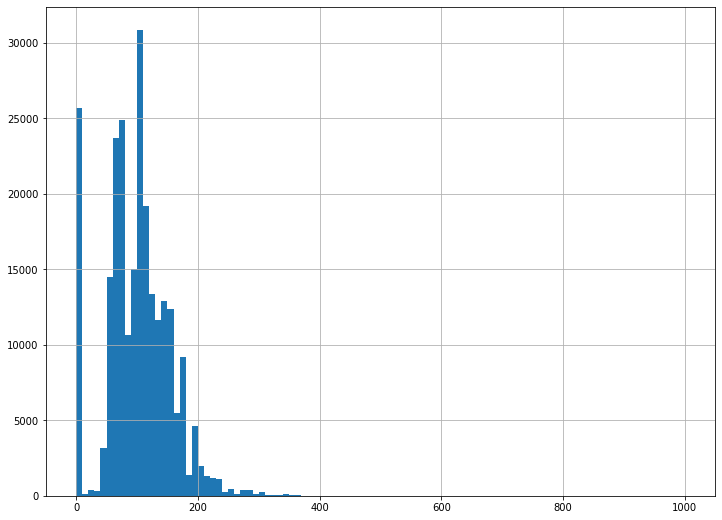

In [ ]:
filtred_autos_data = filtred_autos_data.query('Power < 1001')
filtred_autos_data['Power'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Power'].describe()

Из графика видно, что многие машины имеют мощность 0. Эти строки не подлежат восстановлению и будут удалены. По правому отсечению выберем границу в 400 л.с.

count    221862.000000
mean        109.824012
std          44.434962
min           1.000000
25%          75.000000
50%         103.000000
75%         136.000000
max         400.000000
Name: Power, dtype: float64

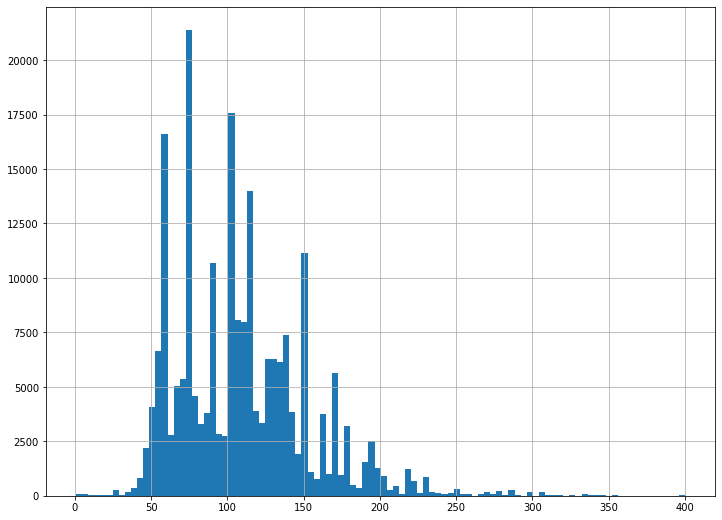

In [ ]:
filtred_autos_data = filtred_autos_data.query('0 < Power < 401')
filtred_autos_data['Power'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Power'].describe()

Следующими границами выберу 25 и 350 л.с.

count    221412.000000
mean        109.878900
std          43.985727
min          25.000000
25%          75.000000
50%         103.000000
75%         136.000000
max         350.000000
Name: Power, dtype: float64

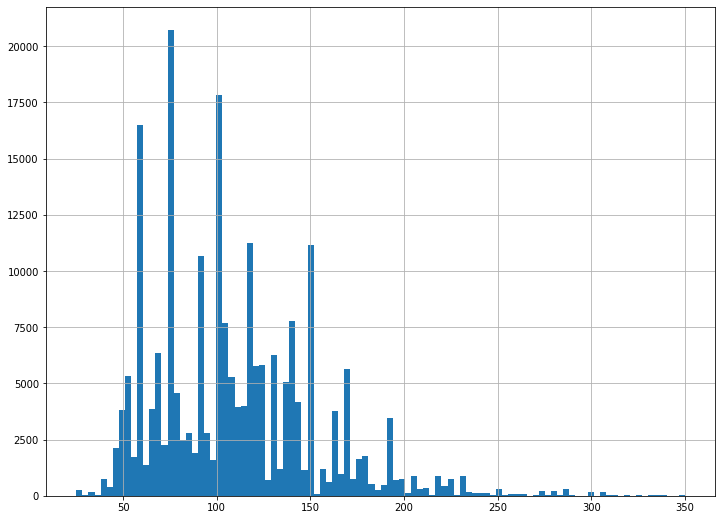

In [ ]:
good_autos_data = filtred_autos_data.query('24 < Power < 351')
good_autos_data['Power'].hist(bins=100, figsize=(12,9))
good_autos_data['Power'].describe()

In [ ]:
good_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221412 entries, 3 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       221412 non-null  object
 1   Gearbox           221412 non-null  object
 2   Power             221412 non-null  int64 
 3   Kilometer         221412 non-null  int64 
 4   FuelType          221412 non-null  object
 5   Brand             221412 non-null  object
 6   NotRepaired       221412 non-null  object
 7   RegistrationYear  221412 non-null  int64 
 8   Model             221412 non-null  object
 9   Price             221412 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 18.6+ MB


Проведу замену столбцов Gearbox и NotRepaired на булев тип.

* IsManualGearbox. 1 (manual) - означает механическую коробку передач. 0 (auto) - автоматическую.
* IsNotRepaired. 0 (no) - означает машину без ремонта. 1 (yes) - с ремонтом.

In [ ]:
good_autos_data['IsManualGearbox'] = 0
good_autos_data.loc[good_autos_data['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
display(good_autos_data['IsManualGearbox'].value_counts())
good_autos_data['Gearbox'].value_counts()

1    186647
0     34765
Name: IsManualGearbox, dtype: int64

manual    186647
auto       34765
Name: Gearbox, dtype: int64

In [ ]:
good_autos_data['IsNotRepaired'] = 1
good_autos_data.loc[good_autos_data['NotRepaired'] == 'yes', 'IsNotRepaired'] = 0
display(good_autos_data['IsNotRepaired'].value_counts())
good_autos_data['NotRepaired'].value_counts()

1    197739
0     23673
Name: IsNotRepaired, dtype: int64

no                163035
unknown_repair     34704
yes                23673
Name: NotRepaired, dtype: int64

Удалю ненужные столбцы и уменьшу размерность хранения типа для ускорения работы с дата фреймом.

In [ ]:
good_autos_data.drop(['NotRepaired','Gearbox'], inplace=True, axis=1)
good_autos_data['IsNotRepaired'] = pd.to_numeric(good_autos_data['IsNotRepaired'], downcast='integer')
good_autos_data['IsManualGearbox'] = pd.to_numeric(good_autos_data['IsManualGearbox'], downcast='integer')
good_autos_data['RegistrationYear'] = pd.to_numeric(good_autos_data['RegistrationYear'], downcast='integer')
good_autos_data['Power'] = pd.to_numeric(good_autos_data['Power'], downcast='integer')
good_autos_data['Kilometer'] = pd.to_numeric(good_autos_data['Kilometer'], downcast='integer')
good_autos_data['Price'] = pd.to_numeric(good_autos_data['Price'], downcast='integer')
good_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221412 entries, 3 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       221412 non-null  object
 1   Power             221412 non-null  int16 
 2   Kilometer         221412 non-null  int32 
 3   FuelType          221412 non-null  object
 4   Brand             221412 non-null  object
 5   RegistrationYear  221412 non-null  int16 
 6   Model             221412 non-null  object
 7   Price             221412 non-null  int16 
 8   IsManualGearbox   221412 non-null  int8  
 9   IsNotRepaired     221412 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 11.0+ MB


In [ ]:
print('Уменьшение использования памяти на {:.2%}'.format(1 - 10.7/43.3))

Уменьшение использования памяти на 75.29%


### Вывод

* Была изучена таблица данных.
* Выведены аномальные и пропущенные значения.
* Отобраны небходимые столбцы для обучения модели.
* Заполнены пропуски в столбцах и удалены некорректные значения.
* Заменены два категориальных признака на численные.
* Выигрыш в памяти составляет 75%, что ускорит обращение к памяти при обучении модели.

## Обучение моделей

Выберу следующие регрессоры для обучения модели:

* LinearRegression
* Ridge
* DecisionTreeRegressor
* CatBoostRegressor
* LGBMRegressor

В качестве метрики для всех моделей будем использовать MSE и в финальной таблице переведем в RMSE. Качество моделей буду проверять на кроссвалидации.

Подготовлю три типа признаков для кроссвалидации:

* Неизмененные. Название original_features.
* Закодированные методом OHE. Название ohe_features.
* Закодированные методом OE. Название ordinal_features.

In [ ]:
# Неизмененные принаки
original_features = good_autos_data.drop('Price', axis=1)

# Прямое кодирование
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model']
cat_features = original_features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
ordinal_features = original_features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]

# OHE кодирование
ohe_features = pd.get_dummies(original_features, drop_first=True)

# Целевой признак
target = good_autos_data['Price']

In [ ]:
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=16052022)

ordinal_features_train = ordinal_features.loc[original_features_train.index, :]
ordinal_features_test = ordinal_features.loc[original_features_test.index, :]

ohe_features_train = ohe_features.loc[original_features_train.index, :]
ohe_features_test = ohe_features.loc[original_features_test.index, :]

### Линейная регрессия

In [ ]:
%%time

regressor = LinearRegression()
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR = (cross_val_score(regressor, 
                             ohe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 1351.121417811355
CPU times: user 40.6 s, sys: 2.94 s, total: 43.5 s
Wall time: 24.2 s


In [ ]:
%%time

regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                ohe_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 6500514157425.154
CPU times: user 44 s, sys: 3.12 s, total: 47.2 s
Wall time: 27.8 s


Масштабирование признаков ухудшает модель. Откажусь от применение масштаба.

### Регрессия Ridge

In [ ]:
%%time

regressor = Ridge()
hyperparams = [{'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]


print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_R = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'solver': 'auto'}

Grid scores on development set:

1350.781822 for {'solver': 'auto'}
1350.781822 for {'solver': 'svd'}
1350.781822 for {'solver': 'cholesky'}
1963.210818 for {'solver': 'lsqr'}
1769.934861 for {'solver': 'sparse_cg'}

CPU times: user 1min 46s, sys: 9.9 s, total: 1min 56s
Wall time: 1min 8s


### Регрессия DecisionTreeRegressor

Проведу два эксперимента:

* Проверю модель на признаках, закодированных по методу OHE.
* На признаках, закодированных по методу OE.

In [ ]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[16052022]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 17, 'random_state': 16052022}

Grid scores on development set:

1553.097714 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 16052022}
1472.016110 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 16052022}
1377.430993 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 16052022}
1302.625821 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 16052022}
1250.558053 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 16052022}
1207.317255 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 16052022}
1171.442693 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 16052022}
1140.851287 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 16052022}
1112.469217 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 16052022}
1088.383290 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 16052022}
1071.712

In [ ]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[16052022]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 14, 'random_state': 16052022}

Grid scores on development set:

1553.097714 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 16052022}
1470.113387 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 16052022}
1377.239758 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 16052022}
1299.184787 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 16052022}
1245.939718 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 16052022}
1202.638824 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 16052022}
1164.443436 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 16052022}
1129.947934 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 16052022}
1102.739750 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 16052022}
1078.290927 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 16052022}
1060.069

Обучение на OHE данных дало похожий результат, что и порядковое кодирование признаков. Занесем оба эксперимента в финальную таблицу.

### Регрессия CatBoostRegressor

Проведу два эксперимента:

* Обучу модель на данных, закодированных по методу OE.
* Обучу на оригинальных данных с указанием категорий.

In [ ]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[16052022],
                'verbose':[False]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.5, 'random_state': 16052022, 'verbose': False}

Grid scores on development set:

927.272660 for {'learning_rate': 0.1, 'random_state': 16052022, 'verbose': False}
917.377859 for {'learning_rate': 0.5, 'random_state': 16052022, 'verbose': False}
929.040704 for {'learning_rate': 0.8, 'random_state': 16052022, 'verbose': False}

CPU times: user 8min 33s, sys: 9.03 s, total: 8min 42s
Wall time: 4min 29s


In [ ]:
%%time

regressor = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=16052022, 
                              verbose=False, 
                              cat_features=['VehicleType','FuelType','Brand','Model']) 
print('# Train for root_mean_squared_error')
print()
cv_RMSE_CBR_original = (cross_val_score(regressor,
                                original_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR_original)

# Train for root_mean_squared_error

Mean RMSE from CV of CatBoostRegressor = 935.4862278527157
CPU times: user 3min, sys: 2.21 s, total: 3min 2s
Wall time: 1min 34s


### Регрессия LGBMRegressor

In [ ]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[16052022]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 16052022}

Grid scores on development set:

964.519177 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 16052022}
927.102709 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 16052022}
913.082273 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 16052022}
937.391344 for {'learning_rate': 0.3, 'num_leaves': 31, 'random_state': 16052022}
916.136765 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 16052022}
912.866600 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 16052022}
936.914010 for {'learning_rate': 0.5, 'num_leaves': 31, 'random_state': 16052022}
928.334289 for {'learning_rate': 0.5, 'num_leaves': 100, 'random_state': 16052022}
928.502565 for {'learning_rate': 0.5, 'num_leaves': 200, 'random_state': 16052022}

CPU times: user 1min 59s, sys: 2.29 s, total: 2min 

### Вывод

Были изучены 5 регрессионных моделей. Зафиксированы лучшие гиперпараметры и время их выполнения.

## Анализ моделей

Проведу обучение на каждой модели с лучшими гиперпараметрами.

### Линейная регрессия

In [ ]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)

CPU times: user 10 s, sys: 551 ms, total: 10.6 s
Wall time: 5.73 s


In [ ]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: user 151 ms, sys: 71 ms, total: 222 ms
Wall time: 153 ms


In [ ]:
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5

### Регрессия Ridge

In [ ]:
%%time

model = Ridge(solver='svd')
model.fit(ohe_features_train, target_train)

CPU times: user 19.6 s, sys: 869 ms, total: 20.5 s
Wall time: 10.9 s


In [ ]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: user 163 ms, sys: 96 ms, total: 259 ms
Wall time: 159 ms


In [ ]:
final_RMSE_R = mean_squared_error(target_test, target_predict) ** 0.5

### Регрессия DecisionTreeRegressor

In [ ]:
%%time

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=15, 
                              random_state=16052022) 
model.fit(ohe_features_train, target_train)

CPU times: user 3.87 s, sys: 66.8 ms, total: 3.94 s
Wall time: 3.87 s


In [ ]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: user 73 ms, sys: 3 ms, total: 76 ms
Wall time: 75.1 ms


In [ ]:
final_RMSE_DTR_ohe = mean_squared_error(target_test, target_predict) ** 0.5

In [ ]:
%%time

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=13, 
                              random_state=16052022) 
model.fit(ordinal_features_train, target_train)

CPU times: user 395 ms, sys: 1.04 ms, total: 396 ms
Wall time: 398 ms


In [ ]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 15.3 ms, sys: 7 µs, total: 15.3 ms
Wall time: 15.6 ms


In [ ]:
final_RMSE_DTR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5

### Регрессия CatBoostRegressor

In [ ]:
%%time

model = CatBoostRegressor(learning_rate=0.5, 
                          random_state=16052022, 
                          verbose=False) 
model.fit(ordinal_features_train, target_train)

CPU times: user 39 s, sys: 646 ms, total: 39.6 s
Wall time: 20.5 s


In [ ]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 72.1 ms


In [ ]:
final_RMSE_CBR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5

In [ ]:
%%time

model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 200, 
                          random_state=16052022, 
                          verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model']) 
model.fit(original_features_train, target_train)

CPU times: user 44.9 s, sys: 487 ms, total: 45.3 s
Wall time: 23.6 s


In [ ]:
%%time

target_predict = model.predict(original_features_test)

CPU times: user 231 ms, sys: 7 ms, total: 238 ms
Wall time: 141 ms


In [ ]:
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5

### Регрессия LGBMRegressor

In [ ]:
%%time

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=16052022)
model.fit(ordinal_features_train, target_train)

CPU times: user 4.13 s, sys: 105 ms, total: 4.23 s
Wall time: 2.22 s


In [ ]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 990 ms, sys: 7.91 ms, total: 998 ms
Wall time: 527 ms


In [ ]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

### Сравнение моделей

Создам таблицу для сравнения параметров.

In [ ]:
index = ['LinearRegression',
         'Ridge',
         'DecisionTreeRegressor on OHE features',
         'DecisionTreeRegressor on OE features',
         'CatBoostRegressor on OE features',
         'CatBoostRegressor on original features',
         'LGBMRegressor']
data = {'RMSE на CV, евро':[cv_RMSE_LR,
                            cv_RMSE_R,
                            cv_RMSE_DTR_ohe,
                            cv_RMSE_DTR_ordinal,
                            cv_RMSE_CBR_ordinal,
                            cv_RMSE_CBR_original,
                            cv_RMSE_LGBMR],
        'Время обучения на CV, сек':[79,
                                     125,
                                     285,
                                     32,
                                     989,
                                     376,
                                     249],
        'RMSE модели на тестовой выборке, евро':[final_RMSE_LR,
                                                final_RMSE_R,
                                                final_RMSE_DTR_ohe,
                                                final_RMSE_DTR_ordinal,
                                                final_RMSE_CBR_ordinal,
                                                final_RMSE_CBR_original,
                                                final_RMSE_LGBMR],
        'Время обучения модели, сек':[18.1,
                                      31.5,
                                      4.83,
                                      0.479,
                                      126,
                                      89,
                                      14.7],
        'Время предсказания модели, сек':[0.194,
                                          0.103,
                                          0.110,
                                          0.013,
                                          0.066,
                                          0.303,
                                          1.19]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE'] = (scores_data['RMSE на CV, евро'].min() /
                              scores_data['RMSE на CV, евро'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения модели, сек'].min() / 
                              scores_data['Время обучения модели, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, сек'].min() / 
                              scores_data['Время предсказания модели, сек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                   scores_data['Рейтинг времени обучения'] +
                                   scores_data['Рейтинг времени предсказания'])
scores_data

RMSE на CV, евро  \
LinearRegression                             1351.121418   
Ridge                                        1350.781822   
DecisionTreeRegressor on OHE features        1038.838878   
DecisionTreeRegressor on OE features         1044.779072   
CatBoostRegressor on OE features              917.377859   
CatBoostRegressor on original features        935.486228   
LGBMRegressor                                 912.866600   

                                        Время обучения на CV, сек  \
LinearRegression                                               79   
Ridge                                                         125   
DecisionTreeRegressor on OHE features                         285   
DecisionTreeRegressor on OE features                           32   
CatBoostRegressor on OE features                              989   
CatBoostRegressor on original features                        376   
LGBMRegressor                                                 249   

                                        RMSE модели на тестовой выборке, евро  \
LinearRegression                                                  1361.688180   
Ridge                                                             1361.791392   
DecisionTreeRegressor on OHE features                             1033.875960   
DecisionTreeRegressor on OE features                              1048.266176   
CatBoostRegressor on OE features                                   916.452092   
CatBoostRegressor on original features                             934.362787   
LGBMRegressor                                                      912.790373   

                                        Время обучения модели, сек  \
LinearRegression                                            18.100   
Ridge                                                       31.500   
DecisionTreeRegressor on OHE features                        4.830   
DecisionTreeRegressor on OE features                         0.479   
CatBoostRegressor on OE features                           126.000   
CatBoostRegressor on original features                      89.000   
LGBMRegressor                                               14.700   

                                        Время предсказания модели, сек  \
LinearRegression                                                 0.194   
Ridge                                                            0.103   
DecisionTreeRegressor on OHE features                            0.110   
DecisionTreeRegressor on OE features                             0.013   
CatBoostRegressor on OE features                                 0.066   
CatBoostRegressor on original features                           0.303   
LGBMRegressor                                                    1.190   

                                        Рейтинг RMSE  \
LinearRegression                            0.675636   
Ridge                                       0.675806   
DecisionTreeRegressor on OHE features       0.878737   
DecisionTreeRegressor on OE features        0.873741   
CatBoostRegressor on OE features            0.995082   
CatBoostRegressor on original features      0.975820   
LGBMRegressor                               1.000000   

                                        Рейтинг времени обучения  \
LinearRegression                                        0.026464   
Ridge                                                   0.015206   
DecisionTreeRegressor on OHE features                   0.099172   
DecisionTreeRegressor on OE features                    1.000000   
CatBoostRegressor on OE features                        0.003802   
CatBoostRegressor on original features                  0.005382   
LGBMRegressor                                           0.032585   

                                        Рейтинг времени предсказания  \
LinearRegression                                            0.067010   
Ridge                                                       0.126

## Итоговый вывод

В ходе работы было выполнено:

* Загружены данные и проведена предобработка.
* Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
* Выбрана лучшая модель по результатам метрики RMSE и времени обучения.

Для общей оценки по трем параметрам был создан относительный рейтинг. 1 получает регрессор с самым минмальным временем или RMSE. Остальные получают рейтинг как отношение лучшего в столбце к своему значению. Считаем, что все параметры равноценны.

На выбор модели не влияло время обучения на кросвалидации, так как на одном типе данных ее проводят один раз. В то время переобучить модель на новых данных приходится намного чаще.

* Лучшей моделью по трем параметрам качество, скорость обучения и скорость предсказания можно считать DecisionTreeRegressor. Сочетания скорости и точности на подготовленных данных выводит его в лидеры рейтинга. Все остальные показали себя в целом хуже.

* Если рассматривать только оценивание точности, то в лидеры выходит LGBMRegressor. Следом за ним идет CatBoostRegressor и DecisionTreeRegressor занимает третье место.

* LinearRegression и Ridge показали себя на этой задачи очень слабо.

Исходя из полученного рейтинга можно выделить специфику задач для регрессоров.

* Для быстрых решений с хорошей точностью подойдет DecisionTreeRegressor с подготовленными признаками.
* Если в деле важна точность и есть время регрессор LGBMRegressor поможет предсказать лучше всех.
* Для задач, не требующих сильной предобработки и заготовки данных CatBoostRegressor может показать себя очень хорошо.